In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.plot_utils import *
from encoding_information.bsccm_utils import *
from encoding_information.models.gaussian_process import *

from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2024-01-08 13:53:34.854603: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-08 13:53:35.498119: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cublas/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_cupti/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvcc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvrtc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_runtime/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/pyth

Opening BSCCM
Opened BSCCM


## Evaluating the fit of stationary vs nonstationary gaussian processes
Fitting a stationary model helps avoid small eigenvlues when cov mat is computed with a small number of patches

In [2]:
# load images, extract patches, and compute cov mats
edge_crop = 32
patch_size = 10
num_patches_to_use = onp.array([10, 33, 100, 333, 1000, 3333, 10000])
# num_patches_to_use = onp.array([2, 8, 32, 128, 512, 2048, 8192])
num_patches = num_patches_to_use.max()
num_test_set_patches = 4000
num_images = num_patches
num_bootstraps = 10
# channel = 'DPC_Right'
channel = 'LED119'
eigenvalue_floor = 1e-3

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_set_patches, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_set_images = all_images[num_images:]
patches = extract_patches(images, patch_size, num_patches=num_patches)
test_set_patches = extract_patches(test_set_images, patch_size, num_patches=num_test_set_patches)

cov_mats = {}
non_stationary_means = {}
stationary_means = {}
cov_mats_stationary = {}
cov_mats_stationary_optimized = {}
for n_patches in tqdm(num_patches_to_use):
    cov_mats[n_patches] = []
    non_stationary_means[n_patches] = []
    stationary_means[n_patches] = []
    cov_mats_stationary[n_patches] = []
    cov_mats_stationary_optimized[n_patches] = []
    for i in range(num_bootstraps):
        patch_indices = onp.random.choice(np.arange(patches.shape[0]), n_patches, replace=False)
        bootstrapped_patches = patches[patch_indices]
        cov_mat = make_positive_definite(estimate_full_cov_mat(bootstrapped_patches), eigenvalue_floor=eigenvalue_floor)
        non_stationary_mean = np.mean(bootstrapped_patches, axis=0).flatten()
        stationary_mean = non_stationary_mean * np.ones_like(non_stationary_mean)
        gp = StationaryGaussianProcess(bootstrapped_patches)
        cov_mat_stationary = gp.get_cov_mat()
        gp.fit(bootstrapped_patches, num_val_samples=max(4, min(200, int(0.1 * bootstrapped_patches.shape[0]))))
        cov_mat_stationary_optimized = gp.get_cov_mat()

        cov_mats[n_patches].append(cov_mat)
        non_stationary_means[n_patches].append(non_stationary_mean)
        stationary_means[n_patches].append(stationary_mean)
        cov_mats_stationary[n_patches].append(cov_mat_stationary)
        cov_mats_stationary_optimized[n_patches].append(cov_mat_stationary_optimized)


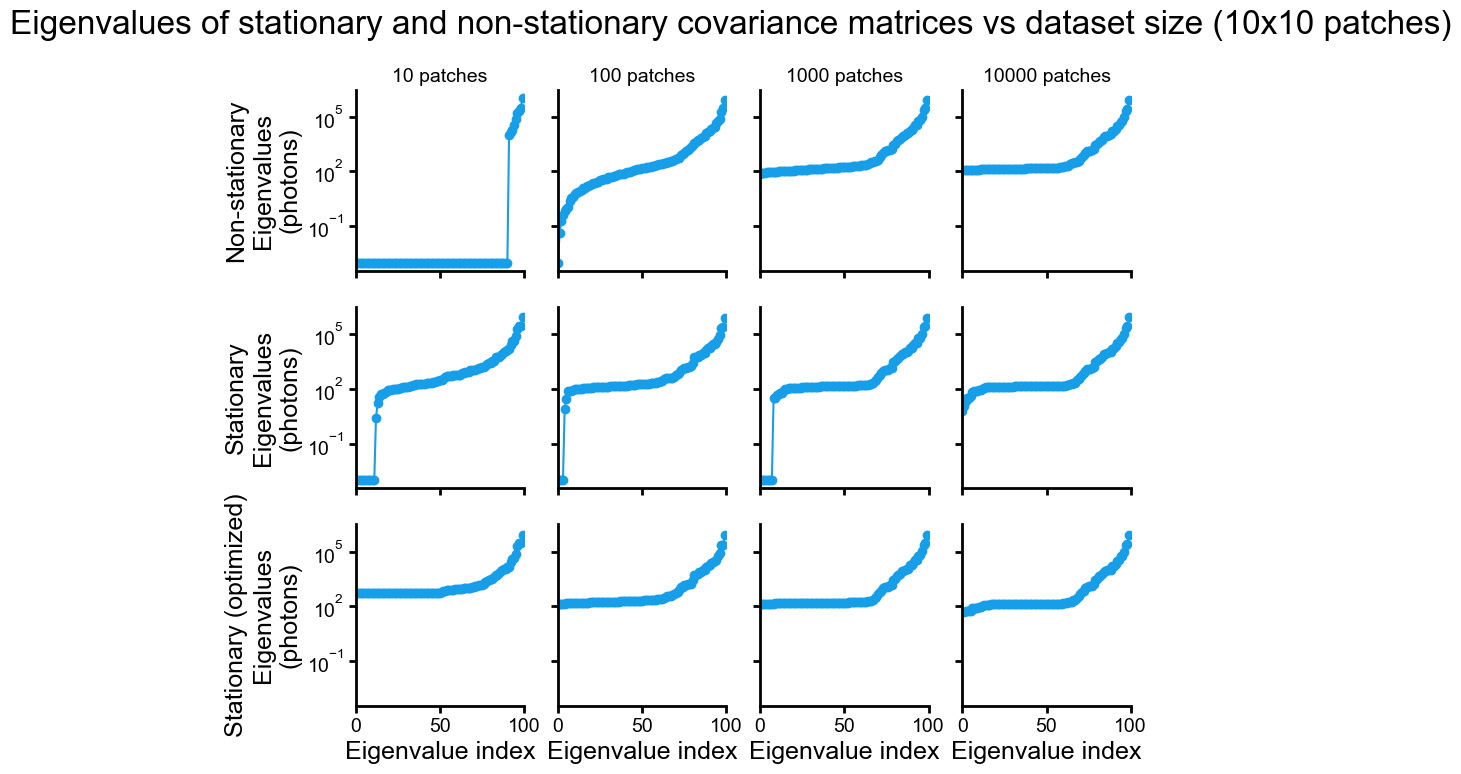

In [ ]:
num_patches_to_show = num_patches_to_use[::2]
# num_patches_to_show = num_patches_to_use
num_to_show = num_patches_to_show.shape[0]

fig, ax = plt.subplots(3, num_to_show, figsize=(num_to_show * 2.5, 8), sharex=True, sharey=True)

for i, n_patches in enumerate(num_patches_to_show):
    eigs = np.linalg.eigvalsh(cov_mats[n_patches][0])
    eigs_stationary = np.linalg.eigvalsh(cov_mats_stationary[n_patches][0])
    eigs_stationary_optimized = np.linalg.eigvalsh(cov_mats_stationary_optimized[n_patches][0])
    ax[0, i].semilogy(eigs, '-o')
    ax[1, i].semilogy(eigs_stationary, '-o')
    ax[2, i].semilogy(eigs_stationary_optimized, '-o')
    clear_spines(ax[0, i])
    clear_spines(ax[1, i])
    clear_spines(ax[2, i])
    

    ax[0, i].set_title(f'{n_patches} patches')
    if i == 0:
        ax[0, i].set_ylabel('Non-stationary\nEigenvalues\n(photons)')
        ax[1, i].set_ylabel('Stationary\nEigenvalues\n(photons)')
        ax[2, i].set_ylabel('Stationary (optimized)\nEigenvalues\n(photons)')
    ax[-1, i].set(xlabel='Eigenvalue index', xlim=[0, len(eigs)])


fig.suptitle('Eigenvalues of stationary and non-stationary covariance matrices vs dataset size ({}x{} patches)'.format(patch_size, patch_size))
fig.savefig('/home/hpinkard_waller/figures/mi_estimation/stationary_vs_full_cov_fits.pdf', transparent=True)
